#Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
from tabulate import tabulate
from matplotlib import pyplot as plt
from random import randint

iris = load_iris()

x = iris.data
y = iris.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)


In [ ]:
class_nr_to_name = {0: iris.target_names[0], 1: iris.target_names[1], 2: iris.target_names[2]}
table_data = np.zeros(shape = (x.shape[0], x.shape[1]+1))
for el_index in range(table_data.shape[0]):
    table_data[el_index] = np.append(x[el_index], y[el_index])

print(tabulate(table_data, headers= np.append(iris.feature_names, "class"), tablefmt='fancy_grid'))

╒═════════════════════╤════════════════════╤═════════════════════╤════════════════════╤═════════╕
│   sepal length (cm) │   sepal width (cm) │   petal length (cm) │   petal width (cm) │   class │
╞═════════════════════╪════════════════════╪═════════════════════╪════════════════════╪═════════╡
│                 5.1 │                3.5 │                 1.4 │                0.2 │       0 │
├─────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────┤
│                 4.9 │                3   │                 1.4 │                0.2 │       0 │
├─────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────┤
│                 4.7 │                3.2 │                 1.3 │                0.2 │       0 │
├─────────────────────┼────────────────────┼─────────────────────┼────────────────────┼─────────┤
│                 4.6 │                3.1 │                 1.5 │                0.2 │       0 │
├───────────────────

In [ ]:
def entropy_func(class_count: int, num_samples: int) -> float:
    '''Part of entropy equasion for one class'''
    return (-1) * (class_count/num_samples) * math.log(class_count/num_samples, 2)


class Group:
    '''Has an array with each group element's class'''

    def __init__(self, group_classes: np.ndarray):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()


    def __len__(self):
        return self.group_classes.size


    def group_entropy(self) -> float:
        '''Calculates entropy of the whole group - sum of class entropies'''
        entropy = 0
        unique_classes, class_counts = np.unique(self.group_classes, return_counts=True)
        for unique_class, class_count in zip(unique_classes, class_counts):
            entropy += entropy_func(class_count, len(self))
        return entropy


In [ ]:
class Node:
    def __init__(self, split_feature: int = -1, split_val: float = -1, depth: int = 0, child_node_a=None, child_node_b=None, val = None, help=None):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val
        self.help = help

    def predict(self, data: np.array):
        '''Predicts element's class given its features data'''
        # Look further
        if self.val is None:
            if data[self.split_feature] <= self.split_val:
                return self.child_node_a.predict(data)
            else:
                return self.child_node_b.predict(data)
        # Found value
        else:
            return self.val



In [ ]:

class DecisionTreeClassifier(object):
    def __init__(self, max_depth: int):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None  #type: Node

    @staticmethod
    def get_split_entropy(group_a: Group, group_b: Group):
        '''Entropy after split (average group_a and group_b entropy)'''
        total_len = len(group_a) + len(group_b)
        return ( (len(group_a)/total_len)*group_a.entropy + (len(group_b)/total_len)*group_b.entropy )

    def get_information_gain(self, parent_group: Group, child_group_a: Group, child_group_b: Group):
        '''Entropy before split - entropy after split'''
        return parent_group.entropy - self.get_split_entropy(child_group_a, child_group_b)

    def split(self, feature_values: np.array, target_classes: np.array, split_point: float) -> tuple[Group, Group]:
        '''Splits data to 2 groups using given feature and split_point'''
        group_a = Group(np.take(target_classes, np.where(feature_values <= split_point)[0]))
        group_b = Group(np.take(target_classes, np.where(feature_values > split_point)[0]))
        return group_a, group_b

    def get_best_feature_split(self, feature_values: np.array, target_classes: np.array) -> tuple[float, float] :
        '''Finds the best split point (with greatest information gain) for a given feature \n
         feature_values - array of elements' feature values \n\t target_classes - array of elements' classes'''
        unique_feature_values = np.unique(feature_values)
        current_group = Group(target_classes)
        best_split_point = 0
        best_inf_gain = -math.inf
        for split_point in unique_feature_values:
            # Creating groups of elements <= or > split_point (using elements' classes)
            group_a, group_b = self.split(feature_values, target_classes, split_point)
            curr_inf_gain = self.get_information_gain(current_group, group_a, group_b)
            if curr_inf_gain > best_inf_gain:
                best_inf_gain = curr_inf_gain
                best_split_point = split_point

        return best_inf_gain, best_split_point

    def get_best_split(self, data: np.array, target_classes: np.array) -> tuple[int, float]:
        '''Finds the best split point from all features'''

        best_inf_gain, best_split_point, best_feature = -math.inf, 0, 0

        for feature_index in range(data.shape[1]):
            if data[0][feature_index] == -1:
                continue
            feature_inf_gain, feature_split_point = self.get_best_feature_split(data[:, feature_index], target_classes)
            if feature_inf_gain > best_inf_gain:
                best_inf_gain = feature_inf_gain
                best_split_point = feature_split_point
                best_feature = feature_index

        return best_feature, best_split_point


    def build_tree(self, data: np.array, target_classes: np.array, depth: int =0, help=None, verbose=0):

        # Achieved max depth / All elements are from the same class
        if (depth == self.max_depth) or (np.unique(target_classes).shape[0] == 1):
            classes, counts = np.unique(target_classes, return_counts=True)
            estimated_value = classes[np.where(counts == counts.max())[0][0]]
            tree = Node(depth=depth, val=estimated_value, help=help)

            est = ""
            if np.unique(target_classes).shape[0] > 1:
                est = "estimated "

            if self.max_depth == 0:
                # Create root
                self.tree = tree
            if verbose:
                print("\t"*depth + est + "final value =", tree.val, tree.help)
            return tree

        # Recursively find best splits for child nodes
        best_feature, split_point = self.get_best_split(data, target_classes)

        # Left branch info
        a_row_indexes = np.where(data[:, best_feature] <= split_point)
        a_data = data[a_row_indexes]
        # a_data = np.delete(a_data, best_feature, 1)
        a_data[:, best_feature] = -1
        a_target_classes = target_classes[a_row_indexes]

        # Right branch info
        b_row_indexes = np.where(data[:, best_feature] > split_point)
        b_data = data[b_row_indexes]
        # b_data = np.delete(b_data, best_feature, 1)
        b_data[:, best_feature] = -1
        b_target_classes = target_classes[b_row_indexes]

        tree =  Node(best_feature, split_point, depth,
                    self.build_tree(a_data, a_target_classes, depth+1, help="L", verbose=verbose),
                    self.build_tree(b_data, b_target_classes, depth+1, help="R", verbose=verbose), help=help)

        if depth == 0:
            # Create root
            self.tree = tree
        if verbose:
            print("\t"*depth + iris.feature_names[tree.split_feature], "split", tree.split_val, tree.help)
        return tree


    def predict(self, data):
        return self.tree.predict(data)



##Tests

In [ ]:
par_group = Group(np.array([0,0,0,1]))
a_group = Group(np.array([0,0,0]))
b_group = Group(np.array([1]))
dc = DecisionTreeClassifier(3)


for i in range(4):
    print(iris.feature_names[i].upper())
    b_gain, b_split = dc.get_best_feature_split(x[:, i], y)
    print(b_gain, b_split)

    a, b = dc.split(x[:, i], y, b_split)
    print("parent entropy", Group(y).entropy, "-", "split entropy", dc.get_split_entropy(a,b), "=", "gain", b_gain)

    print("",a.group_classes, "\n", b.group_classes)


print("\nBest feature:", iris.feature_names[dc.get_best_split(x,y)[0]], dc.get_best_split(x,y)[1])


SEPAL LENGTH (CM)
0.5572326878069267 5.5
parent entropy 1.584962500721156 - split entropy 1.0277298129142294 = gain 0.5572326878069267
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2] 
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
SEPAL WIDTH (CM)
0.28312598916883136 3.3
parent entropy 1.584962500721156 - split entropy 1.3018365115523247 = gain 0.28312598916883136
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2] 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2]
PETAL LENGTH (CM)
0.9182958340544894 1.9
parent entropy 1.584962500721156 - split entropy 0.6666666666666666 

In [ ]:
dc = DecisionTreeClassifier(1)
dc.build_tree(x_train, y_train, verbose=1)
results = {"success": 0, "failure": 0}
for sample, gt in zip(x_test, y_test):
    prediction = dc.predict(sample)
    if prediction == gt:
        results["success"] += 1
    else:
        results["failure"] += 1
    # print(prediction, gt)

print("\nsuccess:", results["success"], " failure:", results["failure"])

	final value = 0 L
	estimated final value = 1 R
petal length (cm) split 1.9 None

success: 9  failure: 6


In [ ]:
dc = DecisionTreeClassifier(3)
dc.build_tree(x_train, y_train, verbose=1)
results = {"success": 0, "failure": 0}
for sample, gt in zip(x_test, y_test):
    prediction = dc.predict(sample)
    if prediction == gt:
        results["success"] += 1
    else:
        results["failure"] += 1
    print(prediction, gt)

print("\nsuccess:", results["success"], " failure:", results["failure"])

	final value = 0 L
			estimated final value = 1 L
			final value = 2 R
		sepal length (cm) split 7.0 L
			estimated final value = 2 L
			final value = 2 R
		sepal length (cm) split 5.9 R
	petal width (cm) split 1.7 R
petal length (cm) split 1.9 None
1 1
2 2
2 2
1 1
0 0
2 2
1 1
0 0
0 0
1 1
2 2
0 0
1 1
2 2
2 2

success: 15  failure: 0


## Plots

In [ ]:

def create_plot(title, label, x_label, y_label, x_data, y_data, x_ticks = None, y_ticks = None):
      plt.plot(x_data, y_data, 'o-', label=label, markersize=3)
      figure = plt.gcf()
      plt.xlabel(x_label)
      plt.ylabel(y_label)
      plt.legend()
      if x_ticks is not None:
          plt.xticks(x_ticks)
      if y_ticks is not None:
          plt.yticks(y_ticks)
      plt.title(label=title)
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def get_accuracy(depth, x_train, x_test, y_train, y_test):
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    result_count = {"success": 0, "failure": 0}
    results = []
    for element, target_class in zip(x_test, y_test):
        prediction = dc.predict(element)
        if prediction == target_class:
            result_count["success"] += 1
        else:
            result_count["failure"] += 1
        results.append((prediction, target_class))

    return (result_count["success"] / (result_count["success"] + result_count["failure"]) * 100, results)


def test_depths(max_depth: int=4):

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
    depths, accuracies, results = [x for x in range(max_depth+1)], [], []
    for depth in range(max_depth+1):
        acc_change, res_change = get_accuracy(depth, x_train, x_test, y_train, y_test)
        accuracies.append(acc_change)
        results.append(res_change)

    create_plot("Accuracies for different max tree depths", "Accuracy",
                "Max depth", "Accuracy (in %)", depths, accuracies,
                np.arange(min(depths), max(depths)+1, 1.0), np.arange(0, 101, 10.0))
    return depths, accuracies, results, y_test.shape[0]


def test_random_data(tries: int, max_depth: int=4):

    try_nrs, accuracies, results = [x+1 for x in range(tries)], [], []
    for try_index in range(tries):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

        acc_change, res_change = get_accuracy(max_depth, x_train, x_test, y_train, y_test)
        accuracies.append(acc_change)
        results.append(res_change)

    create_plot("Accuracies for random data", "Accuracy for depth " + str(max_depth),
                "Tries", "Accuracy (in %)", try_nrs, accuracies,
                np.arange(min(try_nrs), max(try_nrs)+1, 1.0), np.arange(0, 101, 10.0))
    return try_nrs, accuracies, results, y_test.shape[0]


def test_depths_random_data(tries: int, max_depth: int=4):

    random_states = [randint(1,100) for try_index in range(tries)]

    depths, accuracies, depth_accuracies, results = [x for x in range(max_depth+1)], [], [], []
    for depth in range(max_depth+1):

        for try_index in range(tries):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=random_states[try_index])
            acc_change, res_change = get_accuracy(depth, x_train, x_test, y_train, y_test)
            depth_accuracies.append(acc_change)
            results.append(res_change)

        accuracies.append(sum(depth_accuracies)/len(depth_accuracies))
        depth_accuracies = []

    create_plot("Avg accuracies for different max tree depths", "Accuracy",
                "Max depth", "Avg accuracy (in %)", depths, accuracies,
                np.arange(min(depths), max(depths)+1, 1.0), np.arange(0, 101, 10.0))

    return depths, accuracies, results, y_test.shape[0]


def test_test_size(max_depth: int=4, random_state: int=123):

    random_state = randint(1,100)

    test_sizes, accuracies, results = [round(x,2) for x in np.arange(0.05, 1, 0.05)], [], []
    for test_size in test_sizes:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state = random_state)

        acc_change, res_change = get_accuracy(max_depth, x_train, x_test, y_train, y_test)
        accuracies.append(acc_change)
        results.append(res_change)
    create_plot("Accuracies for different test_sizes", "Accuracy for depth " + str(max_depth),
                "Test size", "Accuracy (in %)", test_sizes, accuracies,
                np.arange(min(test_sizes)-0.05, max(test_sizes)+0.10, 0.10), np.arange(50, 101, 10.0))
    return test_sizes, accuracies, results, y_test.shape[0]


###test_depths - Accuracies with different max tree depths given the same data

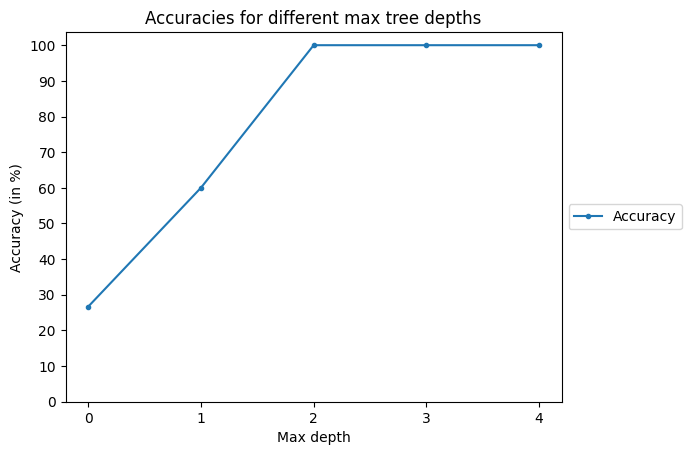

In [ ]:
a = test_depths(4)

###test_random_data - Accuracies with the same depth given random data
Without giving random state


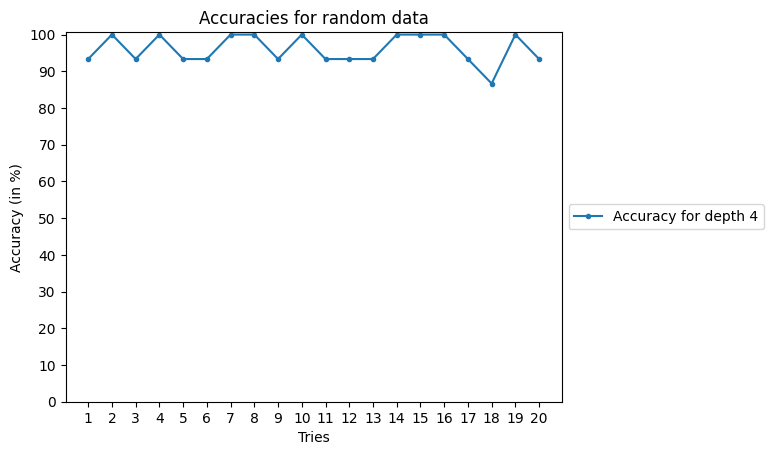

In [ ]:
b = test_random_data(20)

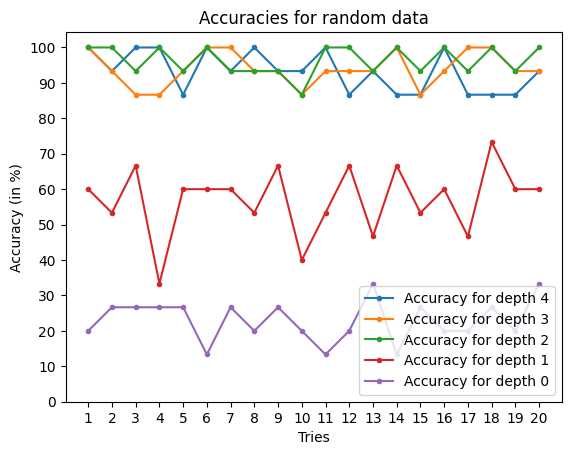

In [ ]:
for depth in range(4,-1,-1):
    test_random_data(20, depth)

###test_depths_random_data - Avg accuracies for different max tree depths



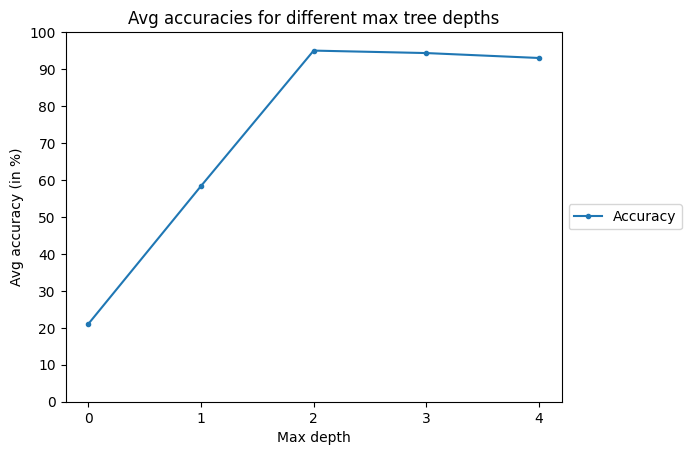

In [ ]:
c = test_depths_random_data(20, 4)

###test_test_size - Accuracies for different test_sizes
Larger test size -> smaller train size = less data to train on, worse results


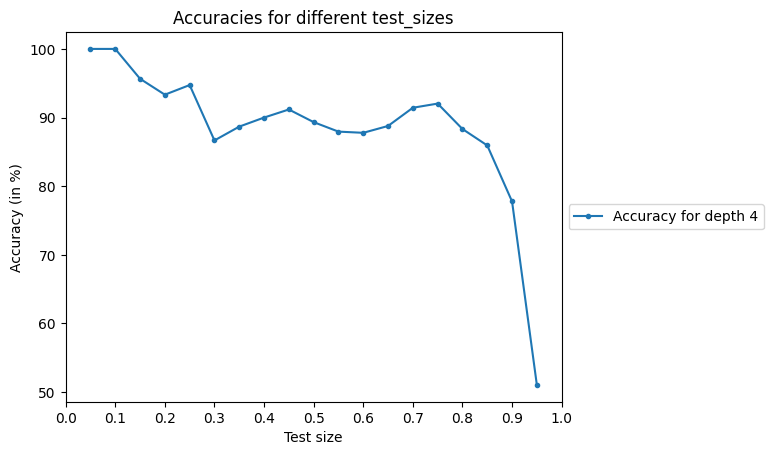

In [ ]:
d = test_test_size(4)

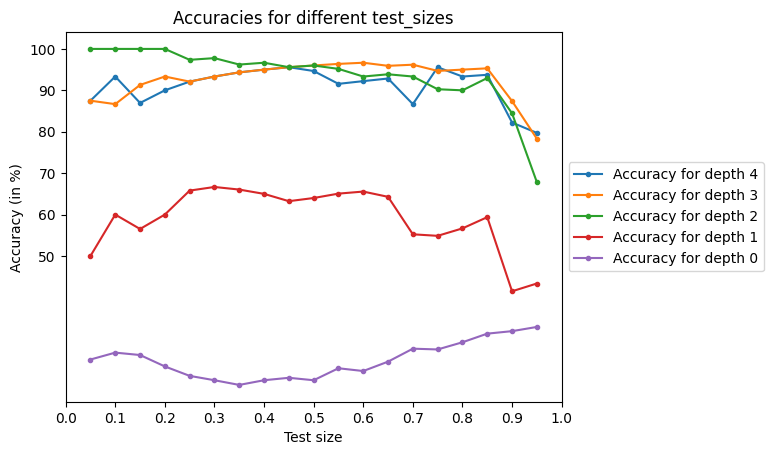

In [ ]:
for depth in range(4,-1,-1):
    test_test_size(depth, 40)